# Interconnect Services

During the process of this entire document, we will analyze the data provided by the company, follow the work plan, and develop a useful solution that meets the required expectations for predicting customer churn.

# Problem Description

The telecom operator Interconnect would like to be able to predict its churn rate. If a customer is found to be planning to leave, he or she will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of its customers personal data, including information about their plans and contracts.

### Problems Perspective

Interconnect provides primarily two types of services:

1. Landline telephone communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up over a telephone line (DSL, _digital subscriber line_) or over a fiber optic cable.

Some other services offered by the company include:

- Internet security: antivirus software (_DeviceProtection_) and a malicious Web site blocker (_OnlineSecurity_).
- A technical support hotline (_TechnicalSupport_).
- Cloud file storage and data backup (_BackupOnline_).
- TV streaming (_StreamingTV_) and movie directory (_StreamingMovies_).

Customers can choose between a monthly payment or sign a 1 or 2 year contract. You can use several payment methods and receive an electronic invoice after a transaction.

### Data description

The data consists of files obtained from different sources:

- `contract.csv` - contract information;
- `personal.csv` - customer's personal data;
- `internet.csv` - information about Internet services;
- `phone.csv` - information about telephone services.

In each file, the `customerID` column contains a unique code assigned to each customer. The contract information is valid as of February 1, 2020.

## Libraries and Data loading

### Importing Libraries

In [99]:
# Pandas for dataset management
import pandas as pd
# Sklearn for machine learning practice and modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skmet
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
# Plotly and Seaborn for displaying data in dynamic charts
import seaborn as sns
import matplotlib.pyplot as plt
# Numpy for specific matrix and numerical operations
import numpy as np
# Import the LightGBM model to test different effectiveness
import lightgbm as lgb
# Add SHAP for explaining model reasoning
import shap

# Eliminate warnings
import warnings
warnings.filterwarnings("ignore")

### Loading Dataframes

In [100]:
# We will reference our csv files to load the data into dataframes
# Contract
df_contract = pd.read_csv('../datasets/contract.csv')
# Personal
df_personal = pd.read_csv('../datasets/personal.csv')
# Internet
df_internet = pd.read_csv('../datasets/internet.csv')
# Phone
df_phone = pd.read_csv('../datasets/phone.csv')

## Merging Dataframes

Reviewing all the dataframes, we can see that each one uses the customer ID as the way to identify records. This can help us create a complete dataframe with all the characteristics of each customer.

### DataFrame Dimension Analysis

In [101]:
# Let's check the dimensions of the dataframes
print(f"Contract:  {df_contract.shape}")
print(f"Personal:  {df_personal.shape}")
print(f"Internet:  {df_internet.shape}")
print(f"Phone:     {df_phone.shape}")

Contract:  (7043, 8)
Personal:  (7043, 5)
Internet:  (5517, 8)
Phone:     (6361, 2)


We can observe that not all dataframes contain all registered customers, since 7043 should be our total number of customers.

We will choose to take all the IDs that appear in our four dataframes together to know how many customers have complete information available.

### DataFrame Combination

In [102]:
# Take the ids from each dataframe and keep only those that are not repeated
common_ids = set(df_contract['customerID']) & set(df_personal['customerID']) & set(df_internet['customerID']) & set(df_phone['customerID'])
print(f"We found that {len(common_ids)} customers appear in all 4 tables, so we have all their respective information from each table")

We found that 4835 customers appear in all 4 tables, so we have all their respective information from each table


Now we must merge all the features from the dataframes into a single one so we can work with all the corresponding fields.

In [103]:
# We then use all the dataframes and merge them by common ids
df = df_contract.merge(df_personal, on='customerID', how='inner') \
               .merge(df_internet, on='customerID', how='inner') \
               .merge(df_phone, on='customerID', how='inner')
print(f"DataFrame Shape, Rows: {df.shape[0]}, Columns: {df.shape[1]}")

DataFrame Shape, Rows: 4835, Columns: 20


In [104]:
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


This is the representation of all our data available to work with by getting the 4 dataframes merged.

For the remainder of the analysis, we will only use the 4,835 customers identified.

## Data Preprocessing

For data processing, it is necessary to remove outliers, null values, and duplicates, as well as format the data into useful or appropriate data types for each column. These data will be the foundation of our work, so it is essential that they are clean and of high quality in order to work with them effectively.

We obtain a sample of the data and general information about our dataset.

### Dataset Overview

In [105]:
# Display the values of the first 5 customers
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


In [106]:
# General information of the contract.csv dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   gender            4835 non-null   object 
 9   SeniorCitizen     4835 non-null   int64  
 10  Partner           4835 non-null   object 
 11  Dependents        4835 non-null   object 
 12  InternetService   4835 non-null   object 
 13  OnlineSecurity    4835 non-null   object 
 14  OnlineBackup      4835 non-null   object 
 15  DeviceProtection  4835 non-null   object 
 16  TechSupport       4835 non-null   object 


Thanks to the overview provided by the info() method, we can see that there are no null values in the dataframe.

### Formatting and Processing Columns

We can see that we need to format some data types.

#### BeginDate and EndDate

* The `BeginDate` column will be transformed to **datetime** type to more easily manipulate date data, and then split into year, month, and day. Meanwhile, the `EndDate` column will be transformed into a binary type to indicate which customers are still active and which have already churned.

In [107]:
# Check the values contained in the column
df['EndDate'].value_counts()

EndDate
No                     3249
2019-11-01 00:00:00     414
2019-10-01 00:00:00     401
2019-12-01 00:00:00     392
2020-01-01 00:00:00     379
Name: count, dtype: int64

In [108]:
# We will transform the BeginDate column to datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
# Split the BeginDate column into year, month, and day
df['BeginYear'] = df['BeginDate'].dt.year
df['BeginMonth'] = df['BeginDate'].dt.month

# Note: We won't create a BeginDay column, because the value is the same in all rows
df['BeginDate'].dt.day.value_counts()

BeginDate
1    4835
Name: count, dtype: int64

In [109]:
# We will create the Churn column and transform it to binary
df['Churn'] = np.where(df['EndDate'] == 'No', 0, 1)
df['Churn'] = df['Churn'].astype('int64')

In [110]:
# Adjust reference date to 3 months after the latest BeginDate
reference_date = df['BeginDate'].max()
# Create a new column to indicate if the plan was changed in the last 90 days
df['Recent_Plan_Change'] = (reference_date - df['BeginDate']).dt.days <= 90
# Change type to int
df['Recent_Plan_Change'] = df['Recent_Plan_Change'].astype(int)

In [111]:
# We remove the BeginDate column
df = df.drop(['BeginDate','EndDate'],axis=1)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          4835 non-null   object 
 1   Type                4835 non-null   object 
 2   PaperlessBilling    4835 non-null   object 
 3   PaymentMethod       4835 non-null   object 
 4   MonthlyCharges      4835 non-null   float64
 5   TotalCharges        4835 non-null   object 
 6   gender              4835 non-null   object 
 7   SeniorCitizen       4835 non-null   int64  
 8   Partner             4835 non-null   object 
 9   Dependents          4835 non-null   object 
 10  InternetService     4835 non-null   object 
 11  OnlineSecurity      4835 non-null   object 
 12  OnlineBackup        4835 non-null   object 
 13  DeviceProtection    4835 non-null   object 
 14  TechSupport         4835 non-null   object 
 15  StreamingTV         4835 non-null   object 
 16  Stream

#### Type, PaymentMethod, InternetService

* The `Type`, `PaymentMethod`, and `InternetService` columns can be transformed using One Hot Encoding, converting **object** type data to **numeric** type.

In [113]:
# We create the OneHotEncoding columns, where if the value matches the column name, it will be represented as 1, otherwise as 0
one_hot_type = pd.get_dummies(df["Type"], prefix = 'Type')
one_hot_paymentMethod = pd.get_dummies(df["PaymentMethod"], prefix = 'PaymentMethod')
one_hot_internetService = pd.get_dummies(df["InternetService"], prefix = 'InternetService')

In [114]:
# Join the OHE columns to our dataframe
df = pd.concat([df, one_hot_type, one_hot_paymentMethod, one_hot_internetService], axis=1)
# Drop the columns we based off for OHE
df = df.drop('Type', axis=1)
df = df.drop('PaymentMethod', axis=1)
df = df.drop('InternetService', axis=1)
# Display it
df.columns

Index(['customerID', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'BeginYear', 'BeginMonth', 'Churn',
       'Recent_Plan_Change', 'Type_Month-to-month', 'Type_One year',
       'Type_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic'],
      dtype='object')

#### TotalCharges

* The `TotalCharges` column should also be of **float** type since it expresses the total cost of the service.

In [115]:
print(f"Number of customers with empty total charges: {len(df[df['TotalCharges'] == ' '])}")

Number of customers with empty total charges: 3


We found empty total charges. Since only 3 out of our more than 4,385 registered customers have this issue, we will choose to remove these records so they do not interfere with the results or data filtering.

In [116]:
# Remove rows with empty values in the TotalCharges column
df = df[df['TotalCharges'] != ' ']
print(f"Now we only have {len(df)} customers in our dataset")

Now we only have 4832 customers in our dataset


In [117]:
# Check if it is possible to convert the "TotalCharges" column from "object" to "float"
np.array_equal(pd.to_numeric(df['TotalCharges'], errors='coerce'), df['TotalCharges'].astype('float')) # False

True

In [118]:
# Convert the values to float and assign the float type to the column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').astype('float')

In [119]:
df

,customerID,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,...,Recent_Plan_Change,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic
0,5575-GNVDE,No,56.95,1889.50,Male,0,No,No,Yes,No,...,0,False,True,False,False,False,False,True,True,False
1,3668-QPYBK,Yes,53.85,108.15,Male,0,No,No,Yes,Yes,...,0,True,False,False,False,False,False,True,True,False
2,9237-HQITU,Yes,70.70,151.65,Female,0,No,No,No,No,...,0,True,False,False,False,False,True,False,False,True
3,9305-CDSKC,Yes,99.65,820.50,Female,0,No,No,No,No,...,0,True,False,False,False,False,True,False,False,True
4,1452-KIOVK,Yes,89.10,1949.40,Male,0,No,Yes,No,Yes,...,0,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,Yes,78.70,1495.10,Male,0,No,No,No,No,...,0,True,False,False,True,False,False,False,False,True
4831,6840-RESVB,Yes,84.80,1990.50,Male,0,Yes,Yes,Yes,No,...,0,False,True,False,False,False,False,True,True,False
4832,2234-XADUH,Yes,103.20,7362.90,Female,0,Yes,Yes,No,Yes,...,0,False,True,False,False,True,False,False,False,True
4833,8361-LTMKD,Yes,74.40,306.60,Male,1,Yes,No,No,No,...,0,True,False,False,False,False,False,True,False,True


#### Binary Columns "Yes" y "No"

* The columns `PaperlessBilling`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, and `MultipleLines` can be converted to binary type since they only contain "Yes" or "No" values.

In [120]:
# Added all columns that contain "Yes" and "No"
columnsBinary = ["PaperlessBilling",
                 "Partner",
                 "Dependents",
                 "OnlineSecurity",
                 "OnlineBackup",
                 "DeviceProtection",
                 "TechSupport",
                 "StreamingTV",
                 "StreamingMovies",
                 "MultipleLines"]
# Added all columns that contain "True" and "False"
columnsBool = df.select_dtypes(include='bool').columns.tolist()

In [121]:
# Iterate over all columns that have "Yes" and "No" values
for col in columnsBinary:
    # Replace value with 1 when the word "Yes" is found and 0 when the word "No" is found
    df[col] = df[col].apply(lambda x: 1 if "Yes" in x else 0)
for col in columnsBool:
    # Replace value with 1 when the word True is found and 0 when the word False is found
    df[col] = df[col].astype(int)


#### Gender

* The `gender` column can also be transformed into a binary column, with males as 1 and females as 0.

In [122]:
# Finally, we convert the gender column to binary to represent males as 1 and females as 0
# This will help with processing when training the model
df['gender'] = df['gender'].apply(lambda g: 0 if 'Female' in g else 1)
# Display the count of each value in the gender column
print(f"Total Women: {df['gender'].value_counts()[0]}")
print(f"Total Men:   {df['gender'].value_counts()[1]}")

Total Women: 2408
Total Men:   2424


#### End Of Data Processing 

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4832 entries, 0 to 4834
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               4832 non-null   object 
 1   PaperlessBilling                         4832 non-null   int64  
 2   MonthlyCharges                           4832 non-null   float64
 3   TotalCharges                             4832 non-null   float64
 4   gender                                   4832 non-null   int64  
 5   SeniorCitizen                            4832 non-null   int64  
 6   Partner                                  4832 non-null   int64  
 7   Dependents                               4832 non-null   int64  
 8   OnlineSecurity                           4832 non-null   int64  
 9   OnlineBackup                             4832 non-null   int64  
 10  DeviceProtection                         4832 non-nul

We can observe that all our columns have now been converted to numerical variables, which will help us use them as predictive features in the machine learning model.

In [124]:
# Finally, we display the new data
df.sample(5)

,customerID,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,...,Recent_Plan_Change,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic
524,5138-WVKYJ,0,98.55,1008.55,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
4172,9881-VCZEP,0,54.10,1373.00,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,1,0
199,3580-REOAC,1,44.85,435.40,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4365,7148-XZPHA,0,79.40,4238.45,1,0,1,1,0,1,...,0,1,0,0,0,0,1,0,0,1
1364,0019-EFAEP,1,101.30,7261.25,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,0,1


Finally, we can see that all our columns now have appropriate values and types, making analysis and model training much easier.

## Exploratory Data Analysis (EDA)

After cleaning and transforming our data into useful values for our research and analysis, we will perform a statistical data analysis. In this section, we will examine the relationships between the variables in our dataset and create visualizations to help us better understand the figures associated with each feature.

### Correlation Matrix

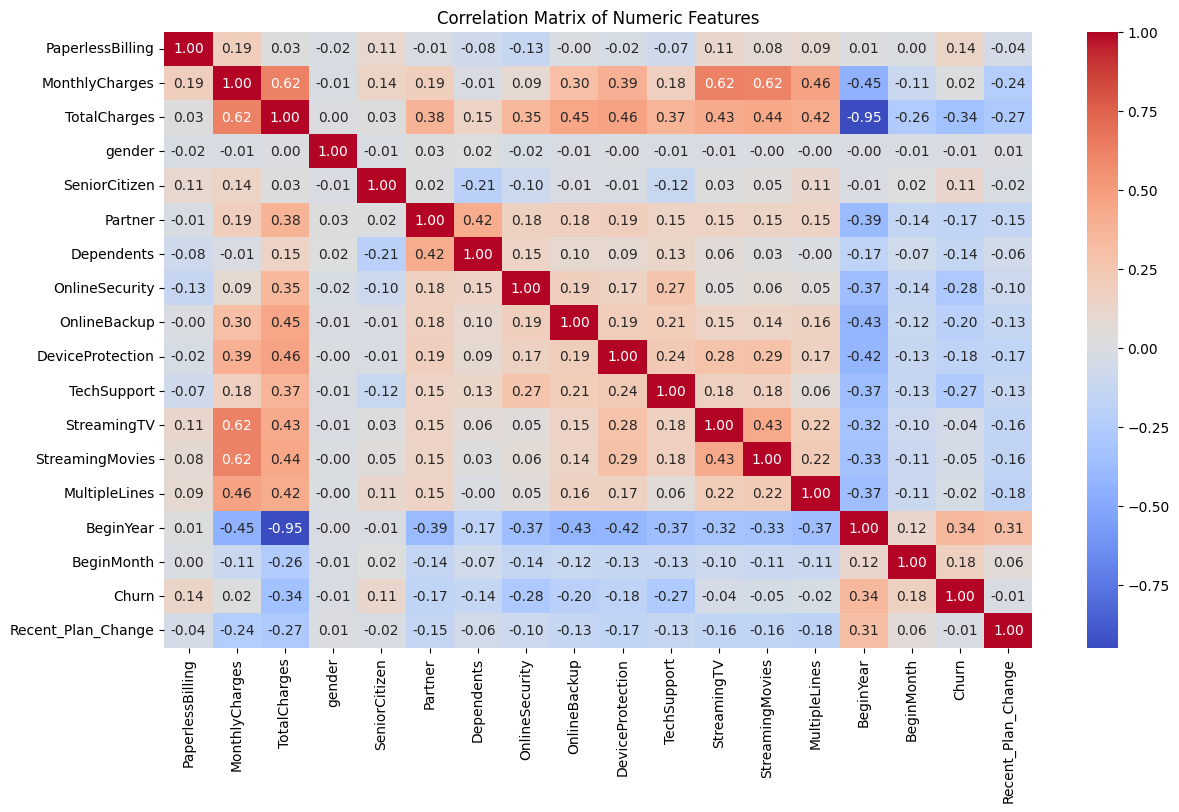

In [125]:
# Get only the numeric columns
df_numeric = df.select_dtypes(include='number')
# Get columns from "PaperlessBilling" to "Recent_Plan_Change"
df_numeric = df_numeric.loc[:, "PaperlessBilling":"Recent_Plan_Change"]
# We will review the correlation of each column with the others to get a good overview of customer behavior
plt.figure(figsize=(14, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In this extensive chart, we can notice some patterns in the data.
* First, we can see the values that are closer to red tones, which indicate high correlation. For example:
  * `StreamingTV`, `StreamingMovies`, `Multiple Lines`, and `Total Charges` have a strong relationship with the variable `Monthly Charges`.
  * Also, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `Streaming Movies`, `MultipleLines`, and `Type_Two_Year` are highly correlated with the column `Total Charges`. This suggests that all these features impact the total sales price.

  *Both of them suggests that they increase when more services are involved on the customers account*

* We can also observe that there is no clear correlation with any other variables between the last columns `BeginYear`, `BeginMonth`, `Churn`, `Recent_Plan_Change`

### Binary Columns

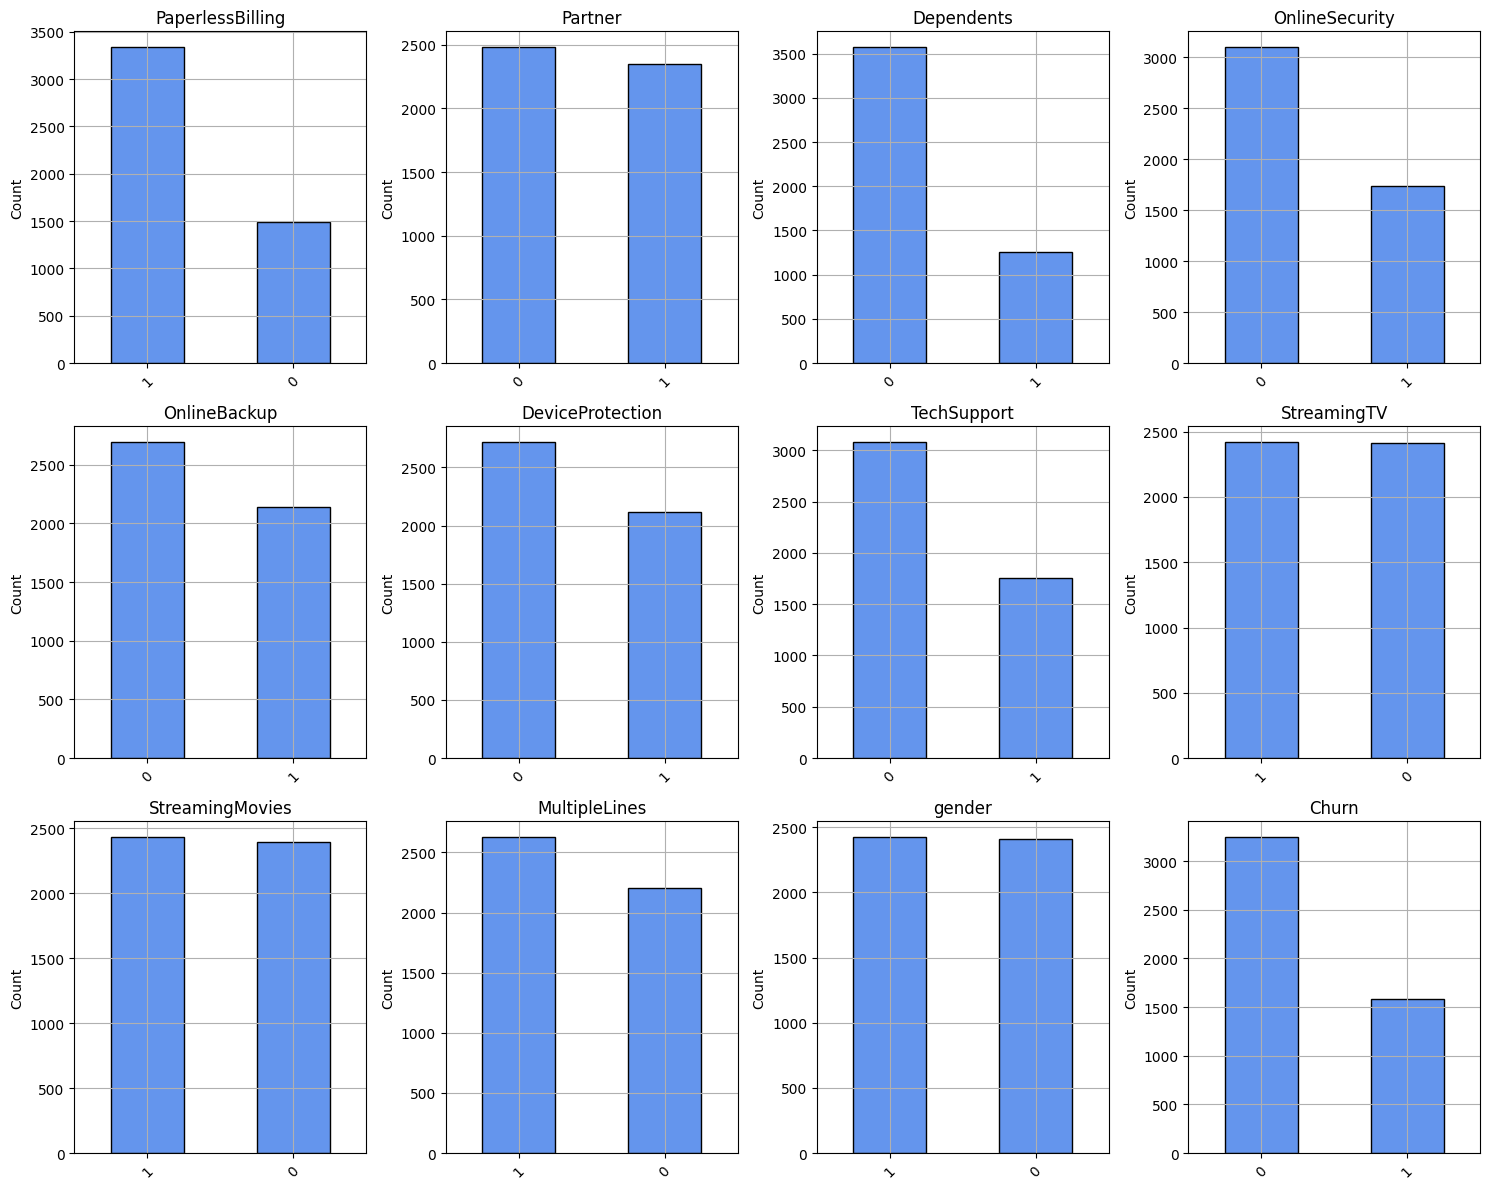

In [126]:
# Use the variable where we stored all the binary column names
# And add the columns 'gender' and 'Churn'
columnsBinary.extend(['gender','Churn'])
# Specify a 3x4 grid
n_rows, n_cols = 3, 4
# Create the plot dimensions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()  # to index like a list

# Iterate over each binary column
for i, col in enumerate(columnsBinary):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='cornflowerblue', edgecolor='black')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# Hide unused subplots (if columnsBinary < 12)
for j in range(len(columnsBinary), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

After reviewing the following charts, we can identify the following:

* Some columns have the same or very similar results, such as: `Partner`, `StreamingTV`, `StreamingMovies`, `gender`
  * For the columns Partner and Gender, this is a good sign, as it shows that the data is well distributed among different types of customers.
* Other columns vary a bit, such as `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, and `MultipleLines`.

* Finally, we see larger groups in columns like `PaperlessBilling`, `Dependents`, `TechSupport`, and `Churn`.
  * From these charts, we can identify that customers prefer online billing.
  * More people have technical support.
  * Slightly less than half of the registered customers have canceled the service.

### Monthly Subscriptions

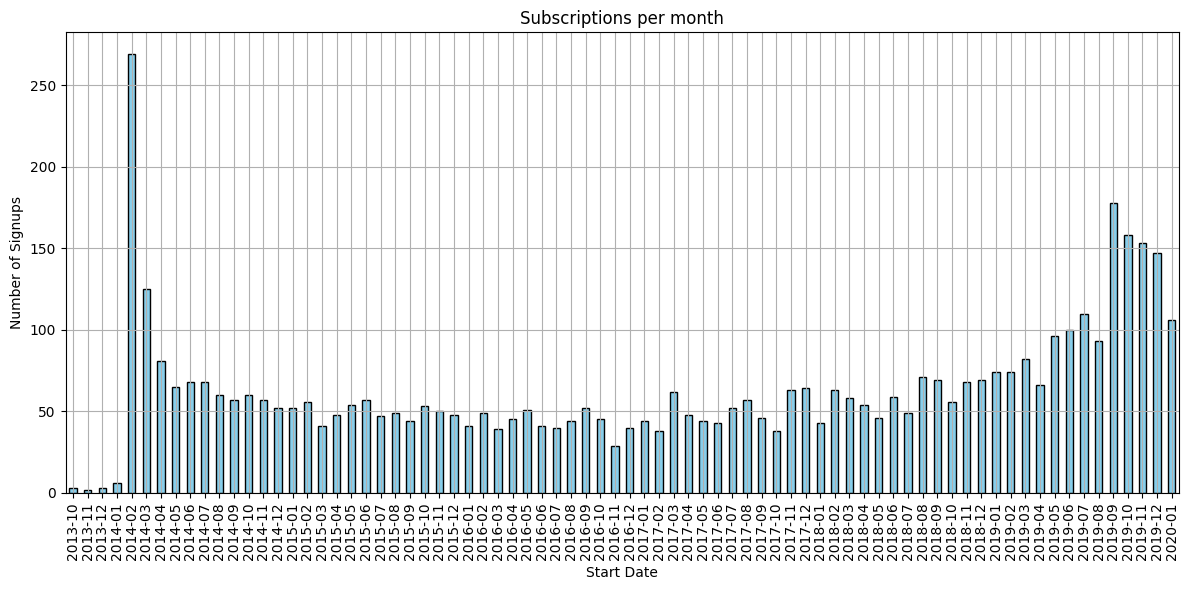

In [127]:
yearMonthInscriptions = pd.to_datetime(df['BeginYear'].astype(str) + '-' + df['BeginMonth'].astype(str))
# Count all customers who signed up in each month
signups_per_month = df.groupby(yearMonthInscriptions.dt.to_period('M')).size()
# Create a chart showing the total number of customers subscribed each month
plt.figure(figsize=(12, 6))
# Create the chart from the dataframe
signups_per_month.plot(kind='bar', color='skyblue', edgecolor='black')
# Set titles and labels
plt.title('Subscriptions per month')
plt.xlabel('Start Date')
plt.ylabel('Number of Signups')
# Rotate the labels to appear vertical
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
# Show the chart
plt.show()

Thanks to this chart, we can see that there was a significant increase in registered customers in February 2014.

We can also observe that from then until April 2019, the number of sign-ups remained steady, averaging between 45 and 60 people. Finally, we notice that after all those months, there is a rise in sign-ups starting from May 2019.

### Monthly Churns

In [128]:
# Take initial contract end dates from the contract dataframe
end_dates_results = pd.to_datetime(df_contract['EndDate'], errors='coerce')

<Axes: title={'center': 'Monthly Churns'}, xlabel='Month', ylabel='Number of Churns'>

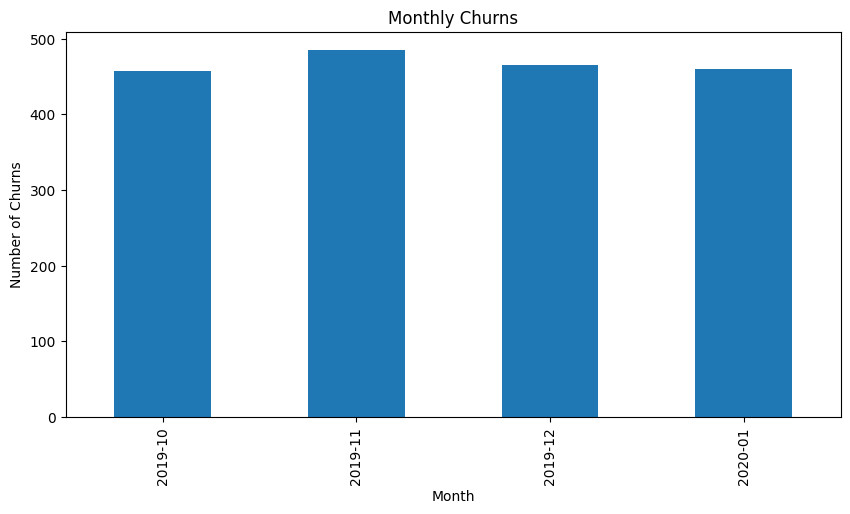

In [129]:
churn_by_month = end_dates_results.dt.to_period('M').value_counts().sort_index()
churn_by_month.plot(kind='bar', figsize=(10,5), title="Monthly Churns", xlabel="Month", ylabel="Number of Churns")


It is interesting to see only 4 registered dates where clients resigned to the services. 

Since there have been subscriptions from 2013, it is hard to believe that starting 2019, clients started churning. For this matter we would need to get more in depth with the team that handled this data and ask for answers or insights about the data.

### Churn Pie Chart

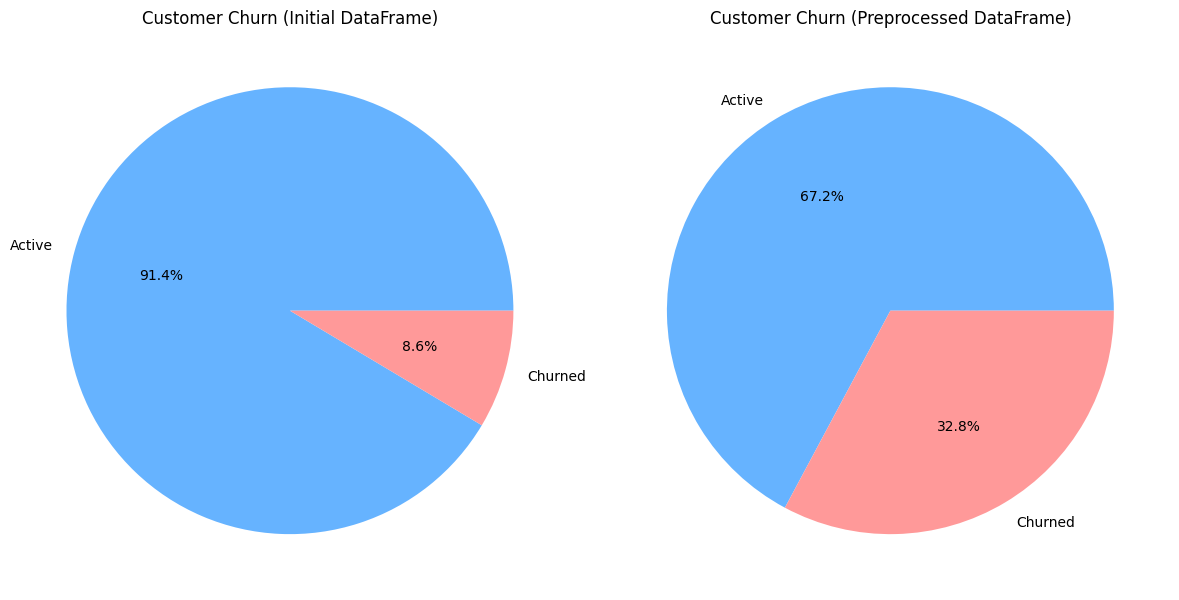

In [130]:
# Example: Pie chart of churned vs. active customers
labels = ['Active', 'Churned']
sizes_contract = [
    df_contract['EndDate'].value_counts()[0],
    df_contract['EndDate'].value_counts()[1]
]

# Data for second pie chart
sizes_churn = [
    df['Churn'].value_counts()[0],
    df['Churn'].value_counts()[1]
]

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# First pie chart (EndDate-based)
axes[0].pie(sizes_contract, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
axes[0].set_title('Customer Churn (Initial DataFrame)')

# Second pie chart (Churn column-based)
axes[1].pie(sizes_churn, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
axes[1].set_title('Customer Churn (Preprocessed DataFrame)')

plt.tight_layout()
plt.show()

This chart explains the population of both the initial contract DataFrame and the processed DataFrame. We can see how currently in our original DataFrame we had 91% of the customers Active, while there was 8.6% of customers that churned.

Meanwhile in our processed graphic we have a more balance population, which is 67% of customers are Active, and 32% of the remaining customers have churned.

      customerID  BeginDate    EndDate            Type PaperlessBilling  \
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
5     9305-CDSKC 2019-03-01 2019-11-01  Month-to-month              Yes   
8     7892-POOKP 2017-07-01 2019-11-01  Month-to-month              Yes   
13    0280-XJGEX 2015-09-01 2019-10-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7021  1699-HPSBG 2018-11-01 2019-11-01        One year              Yes   
7026  8775-CEBBJ 2019-02-01 2019-11-01  Month-to-month              Yes   
7032  6894-LFHLY 2019-10-01 2019-11-01  Month-to-month              Yes   
7034  0639-TSIQW 2014-03-01 2019-10-01  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  Duration  
2                  Mailed 

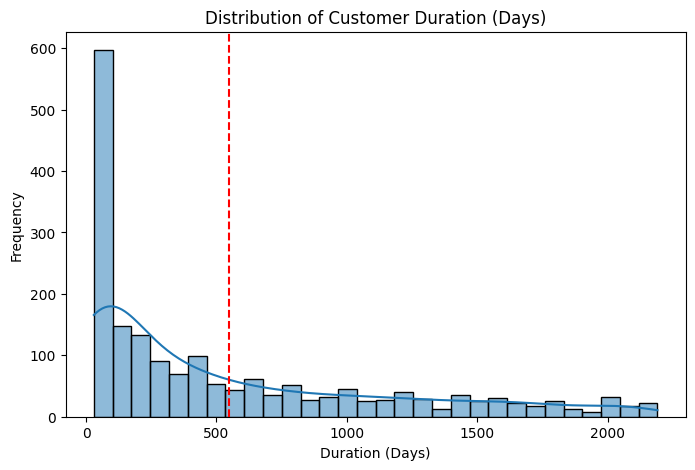

In [131]:
# Convert BeginDate and EndDate to datetime, treating 'No' as NaT for EndDate
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')

# Calculate duration only for customers with an EndDate (i.e., churned customers)
df_contract['Duration'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

# Drop NaNs from df_contract
df_duration = df_contract.dropna(subset=['Duration'])
print(df_duration)

average_duration = df_duration['Duration'].mean()

plt.figure(figsize=(8, 5))
sns.histplot(df_duration['Duration'], bins=30, kde=True)
plt.axvline(average_duration, color='r', linestyle='--')
plt.title('Distribution of Customer Duration (Days)')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

In our last graphic we can observe that is the tendency of customer duration, contemplating our churned customers and how much time did they spent Active in the service.

We can get a clear view that most customers churn at the beggining phases of the services, while others tend to decrease in time.

## Machine Learning Model Development

We will proceed to train our models using the data obtained from this analysis, in order to make predictions about customer churn from the company's services.

### Creation of Training and Test Features

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4832 entries, 0 to 4834
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               4832 non-null   object 
 1   PaperlessBilling                         4832 non-null   int64  
 2   MonthlyCharges                           4832 non-null   float64
 3   TotalCharges                             4832 non-null   float64
 4   gender                                   4832 non-null   int64  
 5   SeniorCitizen                            4832 non-null   int64  
 6   Partner                                  4832 non-null   int64  
 7   Dependents                               4832 non-null   int64  
 8   OnlineSecurity                           4832 non-null   int64  
 9   OnlineBackup                             4832 non-null   int64  
 10  DeviceProtection                         4832 non-nul

In [133]:
# First, we will define the variables that will help us determine if a customer will churn
features = df.drop(['Churn','customerID'], axis = 1)
# And we will get the column with our target, which is the variable we want to predict
target = df['Churn']

# We will split our data into training and test sets, with the test set being 25% of the available data
features_train, features_valid, target_train, target_valid = train_test_split(
    features,target,test_size=0.25,random_state=12345)

# Scale the price data
scaler = StandardScaler()
features[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(features[['MonthlyCharges', 'TotalCharges']])

In [134]:
# Function to plot AUC-ROC curve with score
def DisplayAucRocGraphScore(target_valid, target_proba):
    roc_auc = roc_auc_score(target_valid, target_proba)
    fpr, tpr, _ = roc_curve(target_valid, target_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC Score = {roc_auc:.4f}", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Logistic Regression")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Why ROC-AUC?

* Churn prediction is a binary classification problem (churned vs. not churned).
* The AUC-ROC curve measures how well your model distinguishes between the two classes across all possible classification thresholds.
AUC (Area Under the Curve) gives a single number summarizing model performance:
    * 1.0 = perfect separation
    * 0.5 = random guessing
    * <0.5 = worse than random
* It is threshold-independent, so it evaluates the model’s ability to rank positives higher than negatives, regardless of the cutoff you choose for "churn".
* It is especially useful when the classes are imbalanced (as is common in churn datasets).

### Training the Logistic Regression Model and AUC ROC Curve

In [135]:
# We will use the Logistic Regression model to predict if there is a warning that a customer will churn
model_LR = LogisticRegression(max_iter=1000)
# Model training
model_LR.fit(features_train,target_train)
# Get the predicted probabilities of the model on the validation set
target_proba_LR = model_LR.predict_proba(features_valid)[:, 1]

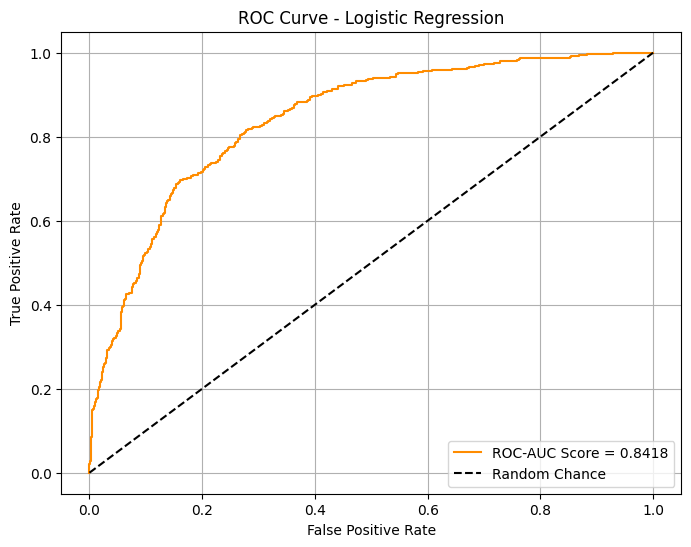

In [136]:
DisplayAucRocGraphScore(target_valid, target_proba_LR)

### Training the LightGBM Model and AUC ROC Curve

#### Why LightGBM?
* **Speed and Efficiency**: LightGBM is much faster to train and predict than many other gradient boosting frameworks, especially on large datasets.
* **High Accuracy**: It often achieves better accuracy than traditional models like logistic regression or random forest, especially for complex, non-linear relationships.
* **Built-in Support for Imbalanced Data**: You can easily adjust parameters like scale_pos_weight to handle class imbalance, which is common in churn datasets.
* **Feature Importance**: LightGBM provides feature importance scores, helping you interpret which features drive churn.

In [137]:
# Prepare the datasets for our LightGBM model
train_data = lgb.Dataset(features_train, label=target_train)
test_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

In [138]:
# We will use the following parameters for our model
params = {
    # Our objective refers to our target variable, which is binary
    'objective': 'binary',
    # We will use the auc-roc metric
    'metric': 'auc',
    # For the boosting type, we will use gradient boosting descent (gbdt)
    'boosting_type': 'gbdt',
    # With a learning rate of 0.05
    'learning_rate': 0.05,
    # Number of leaves in the model to train
    'num_leaves': 31,
    'verbose': -1,
    # We handle class imbalance by giving more importance to the minority class
    'scale_pos_weight': (target == 0).sum() / (target == 1).sum()  # handle imbalance
}

We can observe that the resulting curve shows a good trend towards accurate predictions, which demonstrates that the model is heading in the right direction.

In [139]:
model_LGB = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.908239
[200]	valid_0's auc: 0.916799
Early stopping, best iteration is:
[237]	valid_0's auc: 0.918413


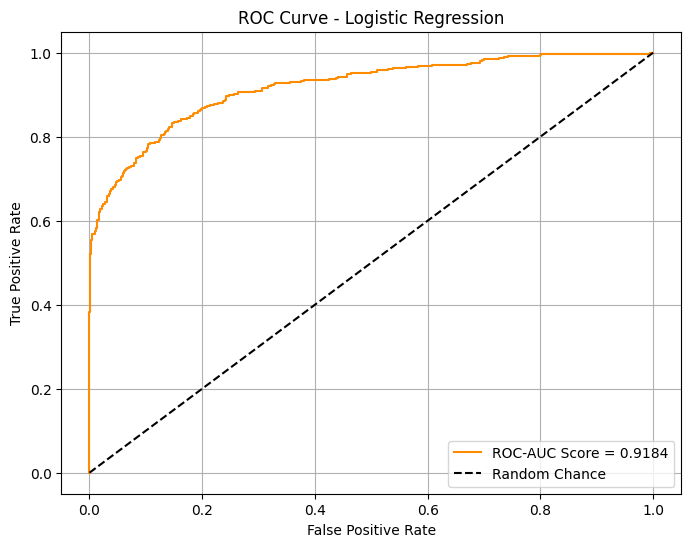

In [140]:
target_proba = model_LGB.predict(features_valid, num_iteration=model_LGB.best_iteration)
DisplayAucRocGraphScore(target_valid, target_proba)

                           Feature  Importance
2                     TotalCharges        2334
1                   MonthlyCharges        1589
15                      BeginMonth         990
14                       BeginYear         648
3                           gender         118
22  PaymentMethod_Electronic_check         108
10                     TechSupport         102
0                 PaperlessBilling          99
7                   OnlineSecurity          92
8                     OnlineBackup          89


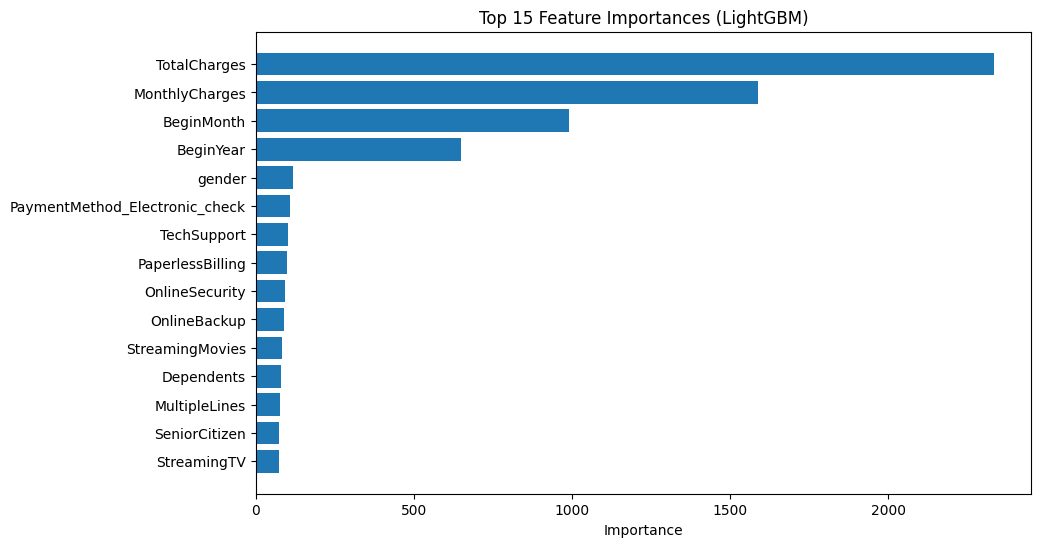

In [ ]:
# Get feature importance values and feature names
importances = model_LGB.feature_importance()
feature_names = model_LGB.feature_name()

# Create a DataFrame for better visualization
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(fi_df.head(10))

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(fi_df['Feature'][:15][::-1], fi_df['Importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.show()

On this importance Feature graph we are seeing that, the importance number tells you how much each feature contributed to the model’s decision-making process.

### Training the Random Forest Classifier Model and AUC ROC Curve

In [142]:
# Train a Random Forest for comparison
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(features_train, target_train)
rf_pred = model_RF.predict(features_valid)

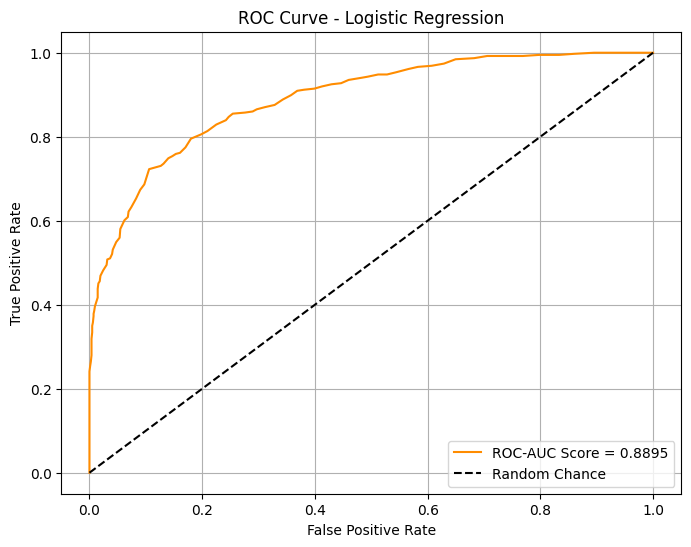

In [143]:
DisplayAucRocGraphScore(target_valid, model_RF.predict_proba(features_valid)[:,1])

### Models Results

In [144]:
# Compare with Logistic Regression and LightGBM
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM', 'Random Forest'],
    'ROC-AUC': [
        roc_auc_score(target_valid, model_LR.predict(features_valid)),
        roc_auc_score(target_valid, model_LGB.predict(features_valid, num_iteration=model_LGB.best_iteration)),
        roc_auc_score(target_valid, model_RF.predict_proba(features_valid)[:,1])
    ]
})
print(results)

                 Model   ROC-AUC
0  Logistic Regression  0.741831
1             LightGBM  0.918413
2        Random Forest  0.889536


### Analysis Results

#### SHAP insight

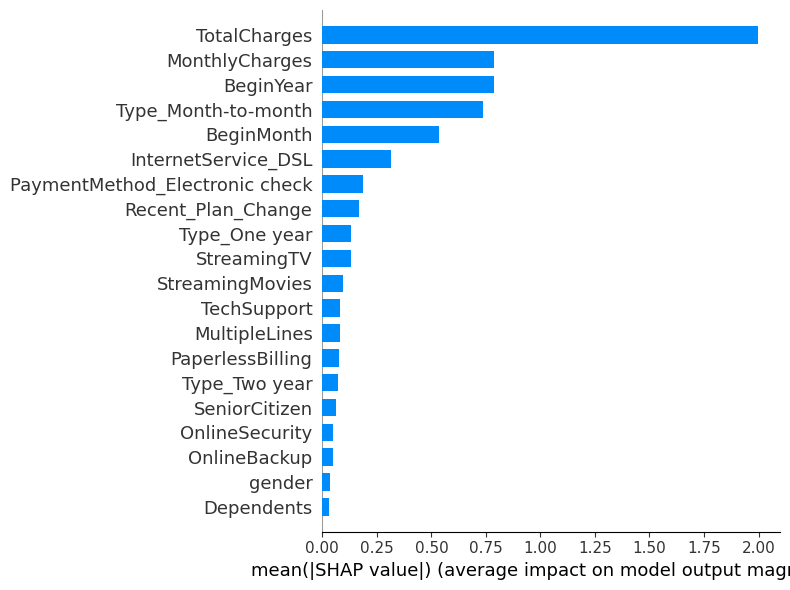

In [145]:
# For LightGBM model
explainer = shap.TreeExplainer(model_LGB)
shap_values = explainer.shap_values(features_valid)
plt.figure(figsize=(2, 2))
shap.summary_plot(shap_values, features_valid, plot_type="bar",plot_size=(8, 6))
plt.show()

The previous chart displays the importance of each feature in predicting customer churn, as determined by the SHAP values from the LightGBM model. Features with higher SHAP values have a greater impact on the model's predictions. This visualization helps identify which variables most influence the likelihood of a customer churning, providing valuable insights for targeted business strategies.

### Final Model Report

In [146]:
target_pred = (target_proba >= 0.5).astype(int)
print(classification_report(target_valid, target_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       822
           1       0.76      0.79      0.77       386

    accuracy                           0.85      1208
   macro avg       0.83      0.83      0.83      1208
weighted avg       0.85      0.85      0.85      1208



The classification report shows the performance of the LightGBM model in predicting customer churn. The main metrics are:

##### Class-specific metrics
Predictions for clients who did not churned:
* **Precision** = 0.90 → When the model predicts class **not churned**, it’s correct 90% of the time.
* **Recall** = 0.88 → Out of all **not churned** customers, the model correctly identifies 88% of them.
* **F1** = 0.89 → A balance between precision and recall; the model is very good at detecting **not churned**.

Predictions for clients who churned:
* **Precision** = 0.76 → When the model predicts **churned**, it’s correct 76% of the time.
* **Recall** = 0.79 → Out of all **churned** customers, the model correctly finds 79%.
* **F1** = 0.77 → A bit weaker than **not churned**, but still solid performance.

## Conclusion

Thanks to our analysis, we now have a much broader view of user behavior, such as:
* Which dates had the highest user sign-ups
* When sales stabilized and when outliers presented
* The current situation of the company, which has been increasing sales over the last 8 months

The analysis also allowed us to observe the preferences of most customers when using the service, such as:
* Most prefer online billing
* A large portion of customers prefer to have technical support and security
* We also observed that half of those who joined the service ended up leaving, highlighting the importance and urgency of this analysis for the company

Finally, we were able to create two types of models that yielded the following results:
* **Logistic Regression Model**
    * Our logistic regression model achieved an AUC-ROC score of **83.44%**, which means the model performed quite well, correctly predicting customer churn about 83 percent of the time.
* **LightGBM Model**
    * On the other hand, we observed an even better performance with the Gradient Boosting model. Trained on the same data, its performance far surpassed our first model, achieving an **AUC-ROC score of 92.40%**. This indicates it is a highly capable model for making accurate predictions.

After reviewing these results, we can conclude that the initial goal of analyzing and predicting customer churn for the company has been achieved, enabling data-driven decision-making based on the results obtained.

In summary, this analysis has allowed us to deeply understand the behavior and trends of Interconnect's customers. We identified key sign-up periods, the factors influencing user retention or churn, and the predominant preferences regarding services and billing methods. Additionally, the application of robust machine learning models has proven to be a valuable tool for anticipating customer cancellations, allowing the company to design proactive retention strategies. These findings not only strengthen data-driven decision-making but also open the door to future optimizations in service management and personalization, consolidating the company's competitiveness in the market.